In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import time
import requests
import io
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
!pip install pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.4 MB/s eta 0:00:00


# Section 1 : Strategic Planning

In [2]:
data = pd.read_csv('/kaggle/input/nasdaq/NQ_continuous_adjusted_1hour_2011_2018.txt')

In [3]:
data

,DateTime,Open,High,Low,Close,Volume
0,2011-01-02 18:00:00,2361.25,2365.00,2360.50,2362.75,1127
1,2011-01-02 19:00:00,2363.00,2364.25,2361.00,2363.50,191
2,2011-01-02 20:00:00,2363.50,2364.00,2362.75,2362.75,207
3,2011-01-02 21:00:00,2362.75,2364.50,2362.50,2364.50,255
4,2011-01-02 22:00:00,2364.50,2369.50,2364.25,2368.25,667
...,...,...,...,...,...,...
48176,2018-12-31 12:00:00,6464.50,6487.50,6451.25,6479.75,33178
48177,2018-12-31 13:00:00,6479.75,6501.50,6461.75,6465.00,22229
48178,2018-12-31 14:00:00,6464.75,6477.25,6436.50,6458.75,33198
48179,2018-12-31 15:00:00,6458.50,6485.25,6433.75,6484.75,55508


In [4]:
# Convert the 'DateTime' column to datetime objects
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S')

# Extract only the date part from the 'DateTime' column
data['Date'] = data['DateTime'].dt.date

# Group the data by the date and calculate the mean of each column for each date
stacked_data = data.groupby('Date').mean().reset_index()

# Display the resulting DataFrame
print(stacked_data)

profitdata = pd.DataFrame(stacked_data)

            Date         Open         High          Low        Close  \
0     2011-01-02  2363.833333  2366.166667  2363.166667  2365.166667   
1     2011-01-03  2386.489583  2389.395833  2384.604167  2387.531250   
2     2011-01-04  2390.218750  2392.052083  2387.864583  2389.666667   
3     2011-01-05  2395.750000  2398.583333  2394.156250  2396.958333   
4     2011-01-06  2415.187500  2417.125000  2413.291667  2415.458333   
...          ...          ...          ...          ...          ...   
2479  2018-12-26  6199.206522  6231.326087  6183.847826  6216.532609   
2480  2018-12-27  6356.782609  6386.271739  6333.032609  6360.217391   
2481  2018-12-28  6465.014706  6483.911765  6436.176471  6462.617647   
2482  2018-12-30  6479.708333  6494.291667  6473.416667  6485.125000   
2483  2018-12-31  6482.529412  6495.779412  6467.750000  6482.911765   

            Volume  
0       443.000000  
1     11489.166667  
2      9081.250000  
3      8802.750000  
4      7396.333333  
...      

In [5]:


# # Set the profit threshold to 0.1%
# profit_threshold = 0.2

# # Create a separate DataFrame containing rows with daily return > 0.1%
# profit_rows = stacked_data[stacked_data['DailyReturn'] > profit_threshold]

# # Display the resulting DataFrame
# print(profit_rows)
# profit = pd.DataFrame(profit_rows)

In [6]:

# Convert the 'DateTime' column to datetime objects
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S')

# Calculate daily returns as the percentage change in 'Close'
data['DailyReturn'] = data['Close'].pct_change() * 100

# Set the profit threshold to 0.1%
profit_threshold = 0.8

# Create a separate DataFrame containing rows with daily return > 0.1%
profitable_rows = data[data['DailyReturn'] > profit_threshold]

# Display the resulting DataFrame
print(profitable_rows)
profit = pd.DataFrame(profitable_rows)

                 DateTime     Open     High      Low    Close  Volume  \
913   2011-02-24 14:00:00  2430.00  2452.25  2429.75  2450.00   44632   
1218  2011-03-15 10:00:00  2366.50  2389.25  2364.75  2387.75   63453   
2097  2011-05-06 08:00:00  2525.50  2548.25  2524.50  2546.50   18766   
2854  2011-06-21 10:00:00  2363.25  2383.25  2362.50  2382.50   64847   
3229  2011-07-13 10:00:00  2499.50  2522.25  2499.00  2521.00   56070   
...                   ...      ...      ...      ...      ...     ...   
48107 2018-12-26 12:00:00  6207.25  6283.25  6201.25  6273.25   71355   
48110 2018-12-26 15:00:00  6302.75  6417.50  6289.25  6416.50   79004   
48132 2018-12-27 14:00:00  6215.25  6289.50  6192.25  6289.00   69158   
48133 2018-12-27 15:00:00  6289.25  6442.25  6261.25  6441.75  108488   
48155 2018-12-28 14:00:00  6460.50  6541.50  6460.50  6536.00   66853   

             Date  DailyReturn  
913    2011-02-24     0.823045  
1218   2011-03-15     0.897951  
2097   2011-05-06     0.

In [7]:
profit.columns


Index(['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Date',
       'DailyReturn'],
      dtype='object')

In [8]:
profit = profit.drop(['High','Low', 'Volume'], axis = 1)

In [9]:
profitdata

,Date,Open,High,Low,Close,Volume
0,2011-01-02,2363.833333,2366.166667,2363.166667,2365.166667,443.000000
1,2011-01-03,2386.489583,2389.395833,2384.604167,2387.531250,11489.166667
2,2011-01-04,2390.218750,2392.052083,2387.864583,2389.666667,9081.250000
3,2011-01-05,2395.750000,2398.583333,2394.156250,2396.958333,8802.750000
4,2011-01-06,2415.187500,2417.125000,2413.291667,2415.458333,7396.333333
...,...,...,...,...,...,...
2479,2018-12-26,6199.206522,6231.326087,6183.847826,6216.532609,26316.217391
2480,2018-12-27,6356.782609,6386.271739,6333.032609,6360.217391,31905.000000
2481,2018-12-28,6465.014706,6483.911765,6436.176471,6462.617647,34732.058824
2482,2018-12-30,6479.708333,6494.291667,6473.416667,6485.125000,3458.833333


# Section 2: LSTM Prediction


In [10]:
stock_final=pd.read_csv('/kaggle/input/nasdaq/NQ_continuous_adjusted_1hour_2011_2018.txt')

In [11]:
stock_final

,DateTime,Open,High,Low,Close,Volume
0,2011-01-02 18:00:00,2361.25,2365.00,2360.50,2362.75,1127
1,2011-01-02 19:00:00,2363.00,2364.25,2361.00,2363.50,191
2,2011-01-02 20:00:00,2363.50,2364.00,2362.75,2362.75,207
3,2011-01-02 21:00:00,2362.75,2364.50,2362.50,2364.50,255
4,2011-01-02 22:00:00,2364.50,2369.50,2364.25,2368.25,667
...,...,...,...,...,...,...
48176,2018-12-31 12:00:00,6464.50,6487.50,6451.25,6479.75,33178
48177,2018-12-31 13:00:00,6479.75,6501.50,6461.75,6465.00,22229
48178,2018-12-31 14:00:00,6464.75,6477.25,6436.50,6458.75,33198
48179,2018-12-31 15:00:00,6458.50,6485.25,6433.75,6484.75,55508


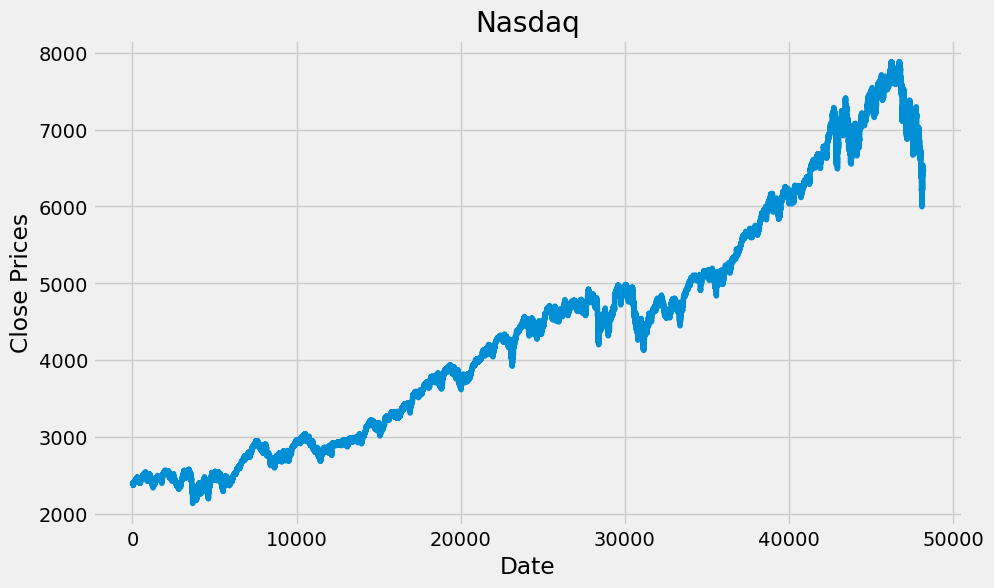

In [12]:
#plotting the close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_final['Close'])
plt.title('Nasdaq')
plt.show()

<AxesSubplot:ylabel='Density'>

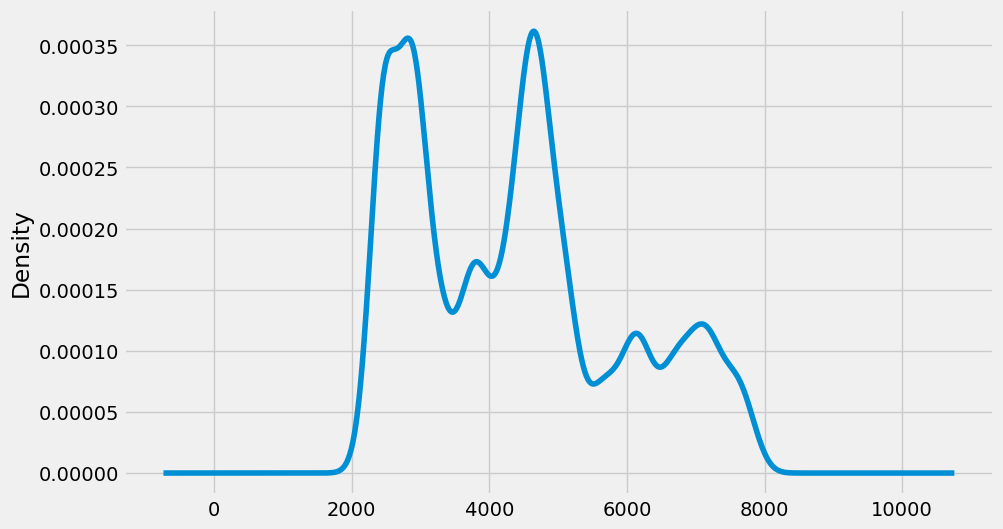

In [13]:
#Distribution of the dataset
stock_final['Close'].plot(kind='kde')

In [14]:
def test_stationarity(timeseries):
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(60).mean()
#     rolstd = timeseries.rolling(60).std()
#     #Plot rolling statistics:
#     plt.plot(timeseries, color='blue',label='Original')
#     plt.plot(rolmean, color='red', label='Rolling Mean')
#     plt.plot(rolstd, color='black', label = 'Rolling Std')
    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
#     ts_log.rolling(12).mean()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean &amp; Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
#     plt.legend(loc='best')
#     plt.title('Rolling Mean and Standard Deviation')
#     plt.show(block=False)
#     fig.set_size_inches(40, 10)
    
    
#     print("Results of dickey fuller test")
#     adft = adfuller(timeseries,autolag='AIC')
#     # output for dft will give us without defining what the values are.
#     #hence we manually write what values does it explains using a for loop
#     output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
#     for key,values in adft[4].items():
#         output['critical value (%s)'%key] =  values
#     print(output)


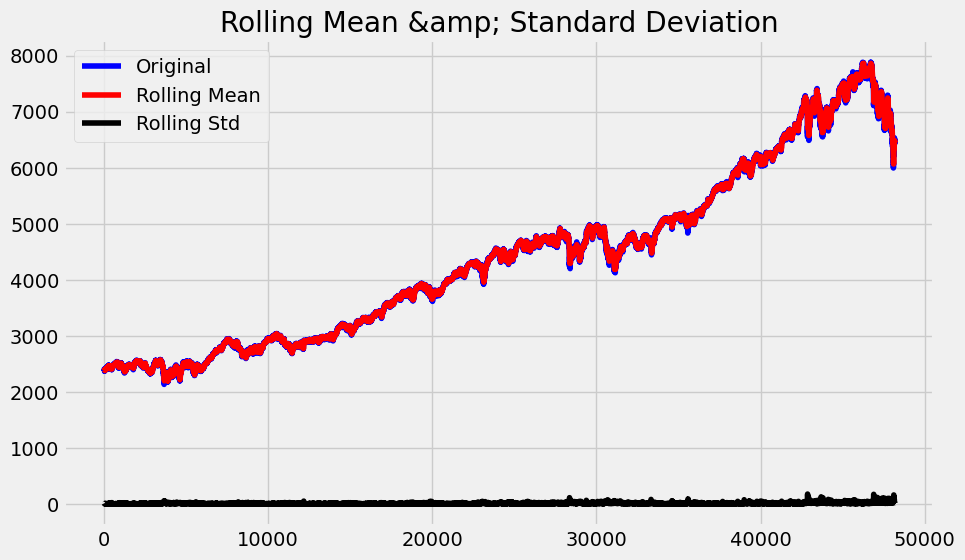

Results of Dickey-Fuller Test:
Test Statistic                    -0.602414
p-value                            0.870436
#Lags Used                        55.000000
Number of Observations Used    48125.000000
Critical Value (1%)               -3.430486
Critical Value (5%)               -2.861600
Critical Value (10%)              -2.566802
dtype: float64


In [15]:
test_stationarity(stock_final['Close'])

<Figure size 1000x600 with 0 Axes>

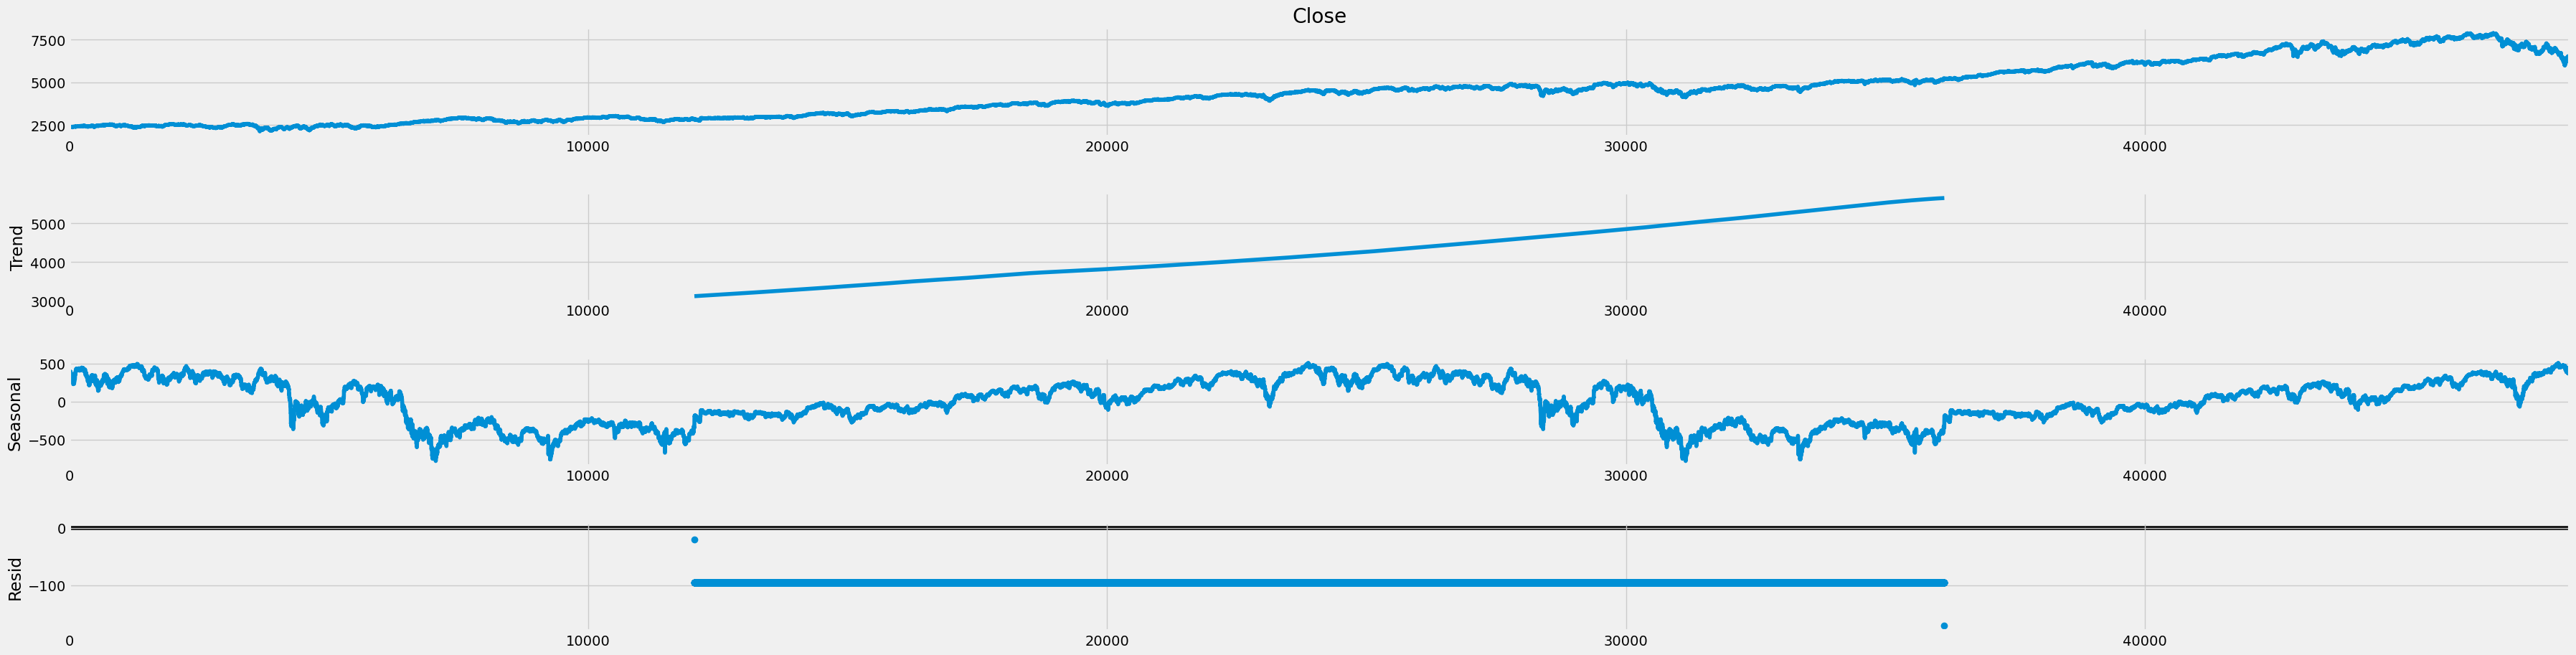

In [16]:
result = seasonal_decompose(stock_final['Close'], period=24090 ,model='additive')                                                  #fill code
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(40, 10)

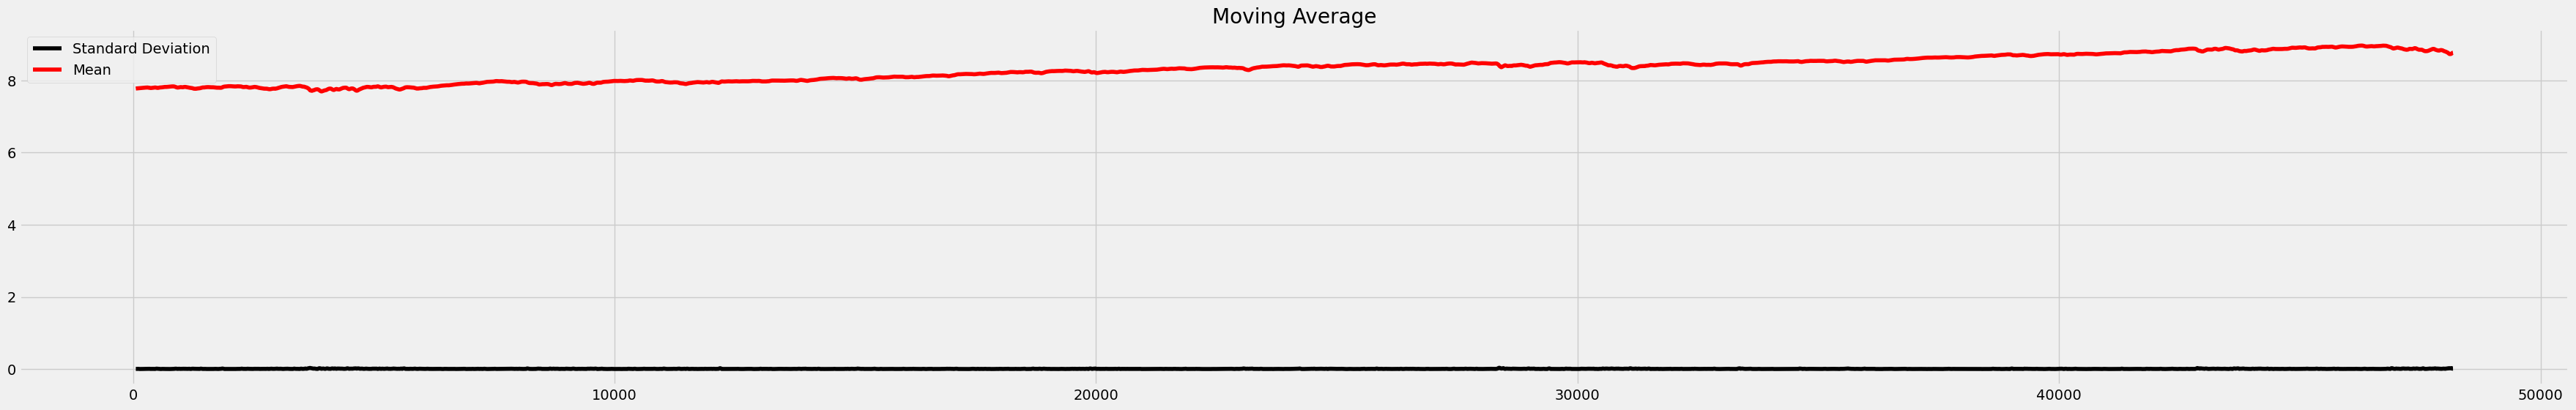

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 6
df_log = np.log(stock_final['Close'])
moving_avg = df_log.rolling(60).mean()
std_dev = df_log.rolling(60).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [18]:
# #Set Target Variable
# output_var = pd.DataFrame(nasdaq['Close'])
# #Selecting the Features
# features = ['Open', 'High', 'Low', 'Volume']

<Figure size 4200x3000 with 0 Axes>

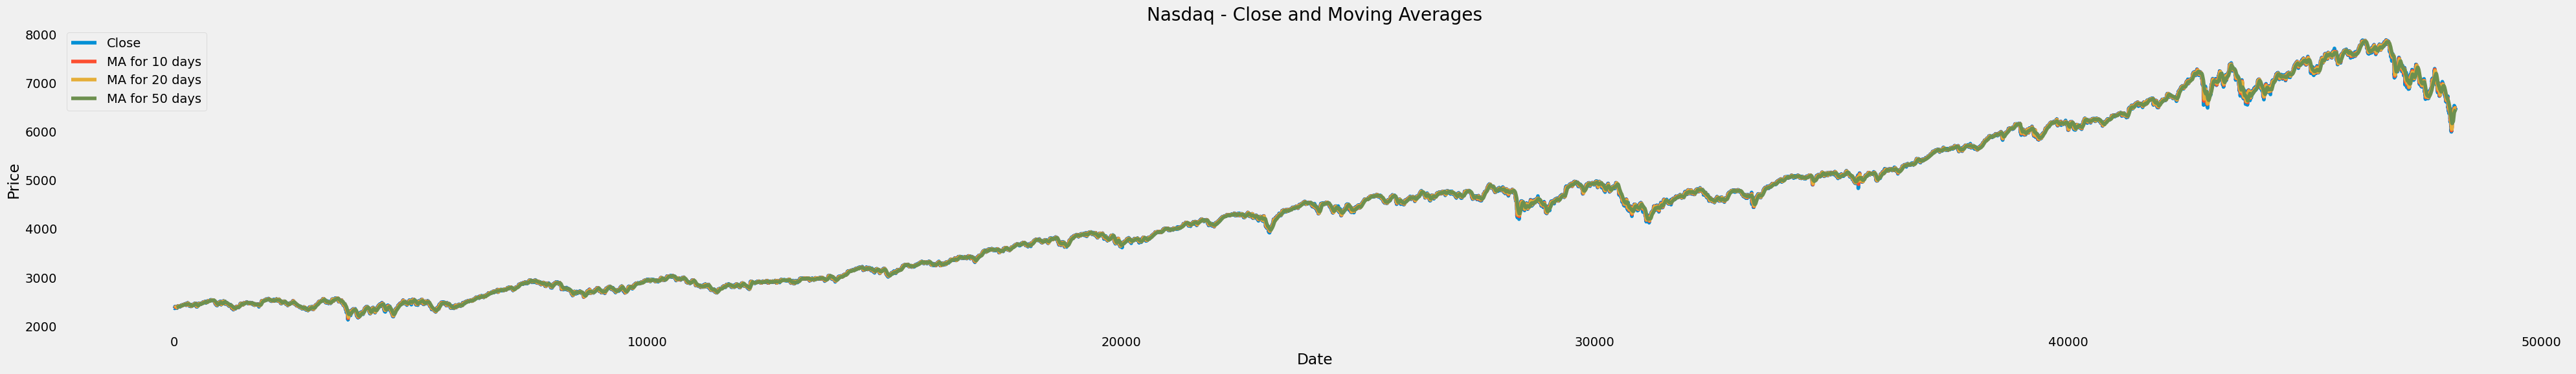

In [19]:
import matplotlib.pyplot as plt

ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    stock_final[column_name] = stock_final['Close'].rolling(ma).mean()

plt.figure(figsize=(42, 30))

# Plot Close price and moving averages
stock_final[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()

# Set title and labels
plt.title('Nasdaq - Close and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


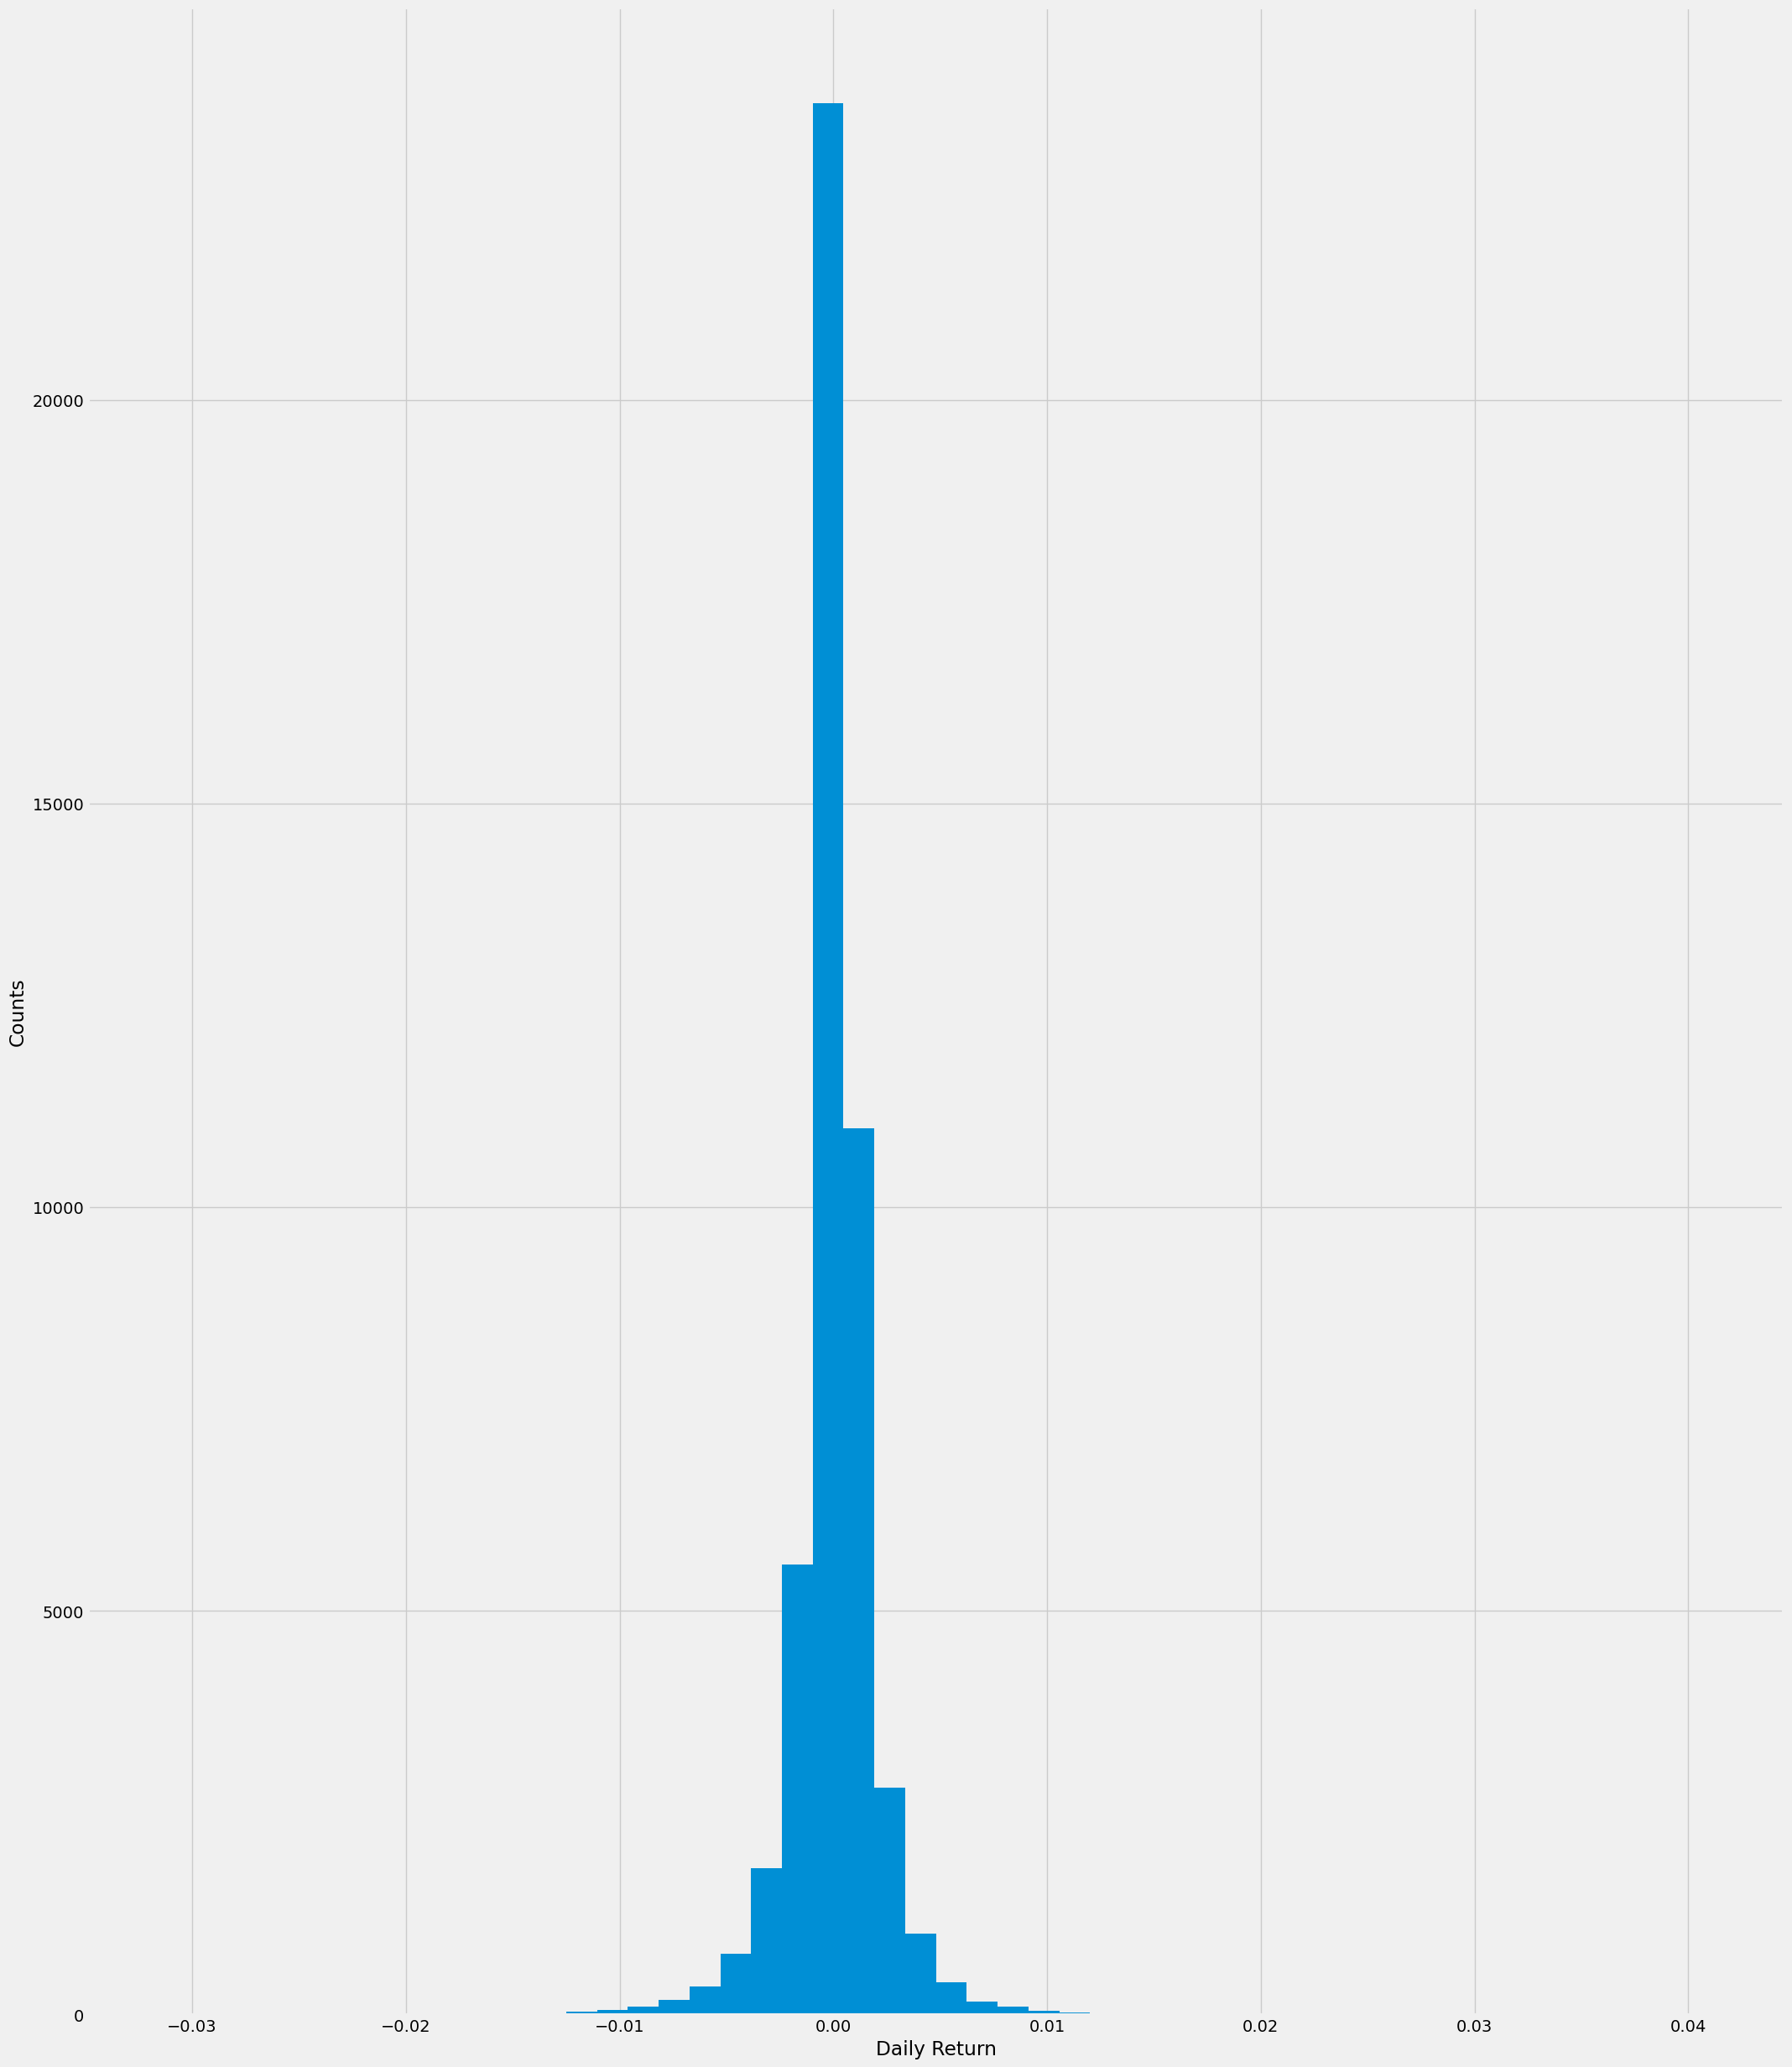

In [20]:
plt.figure(figsize=(42, 49))

stock_final['Daily Return'] = stock_final['Close'].pct_change()
# for i, company in enumerate(company_list, 1):
plt.subplot(2, 2, 1)
stock_final['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
# plt.title(f'{company_name[i - 1]}')    
    
plt.tight_layout()

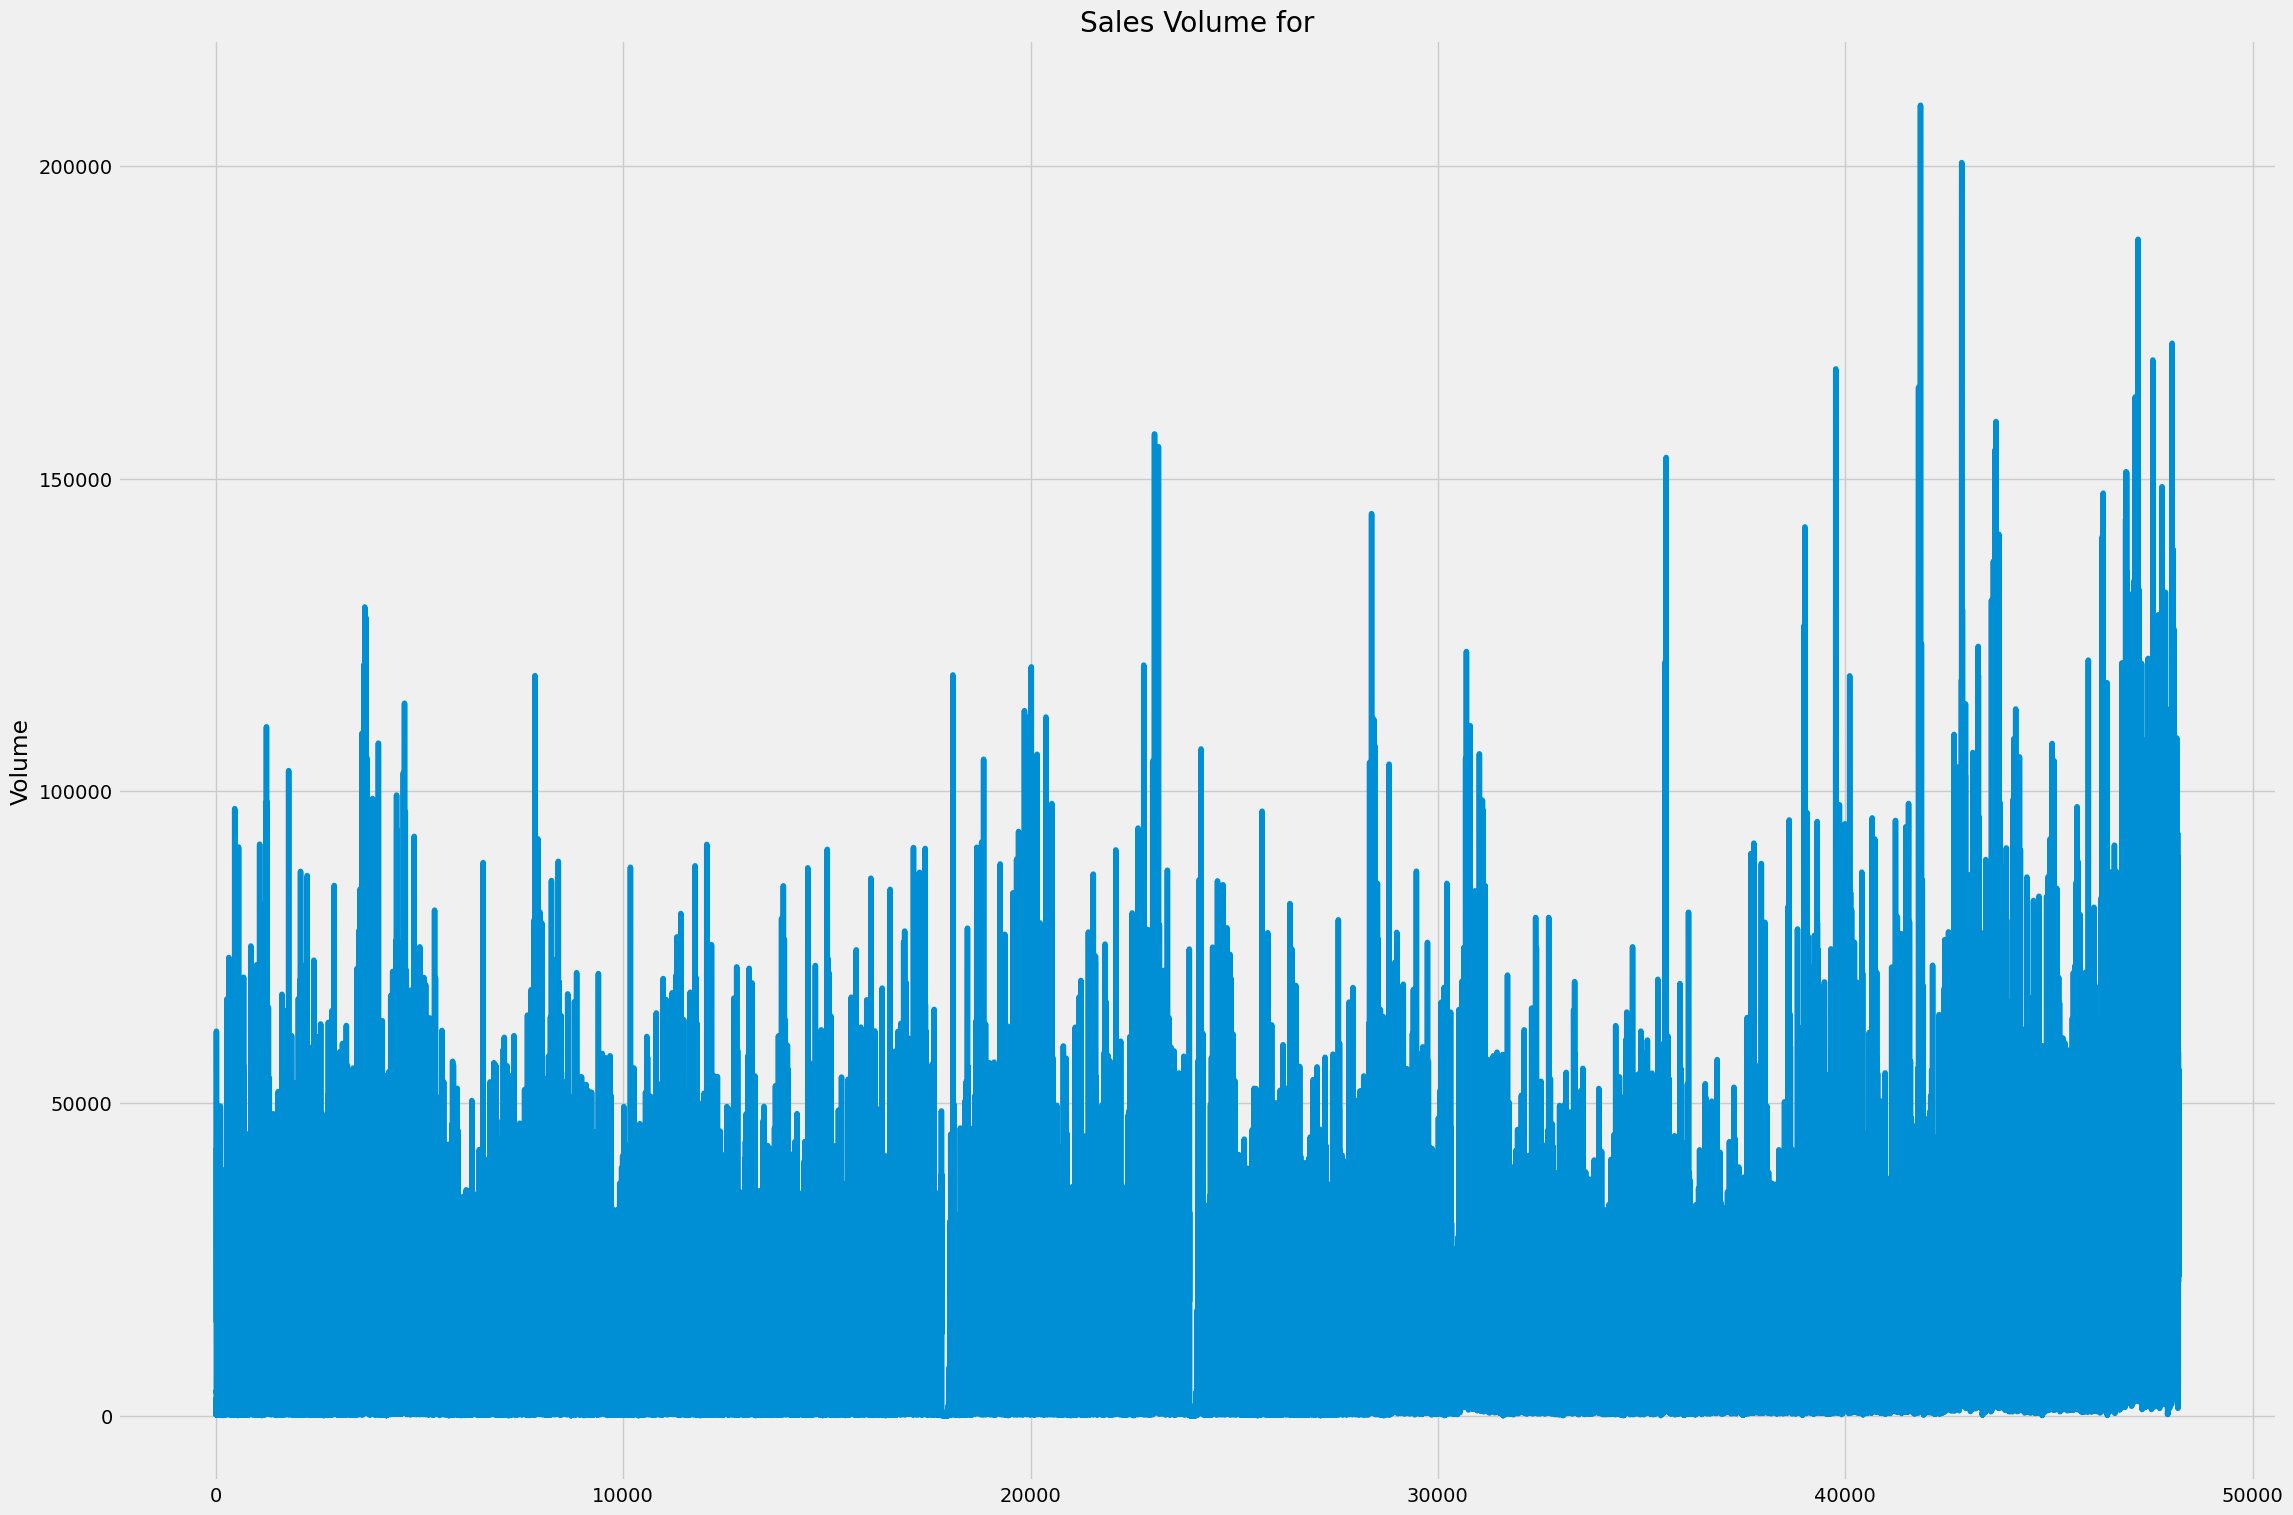

In [21]:
plt.figure(figsize=(45, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)
plt.subplot(2, 2, 1)
stock_final['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume for")

    
    
plt.tight_layout()

In [22]:
from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

In [23]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

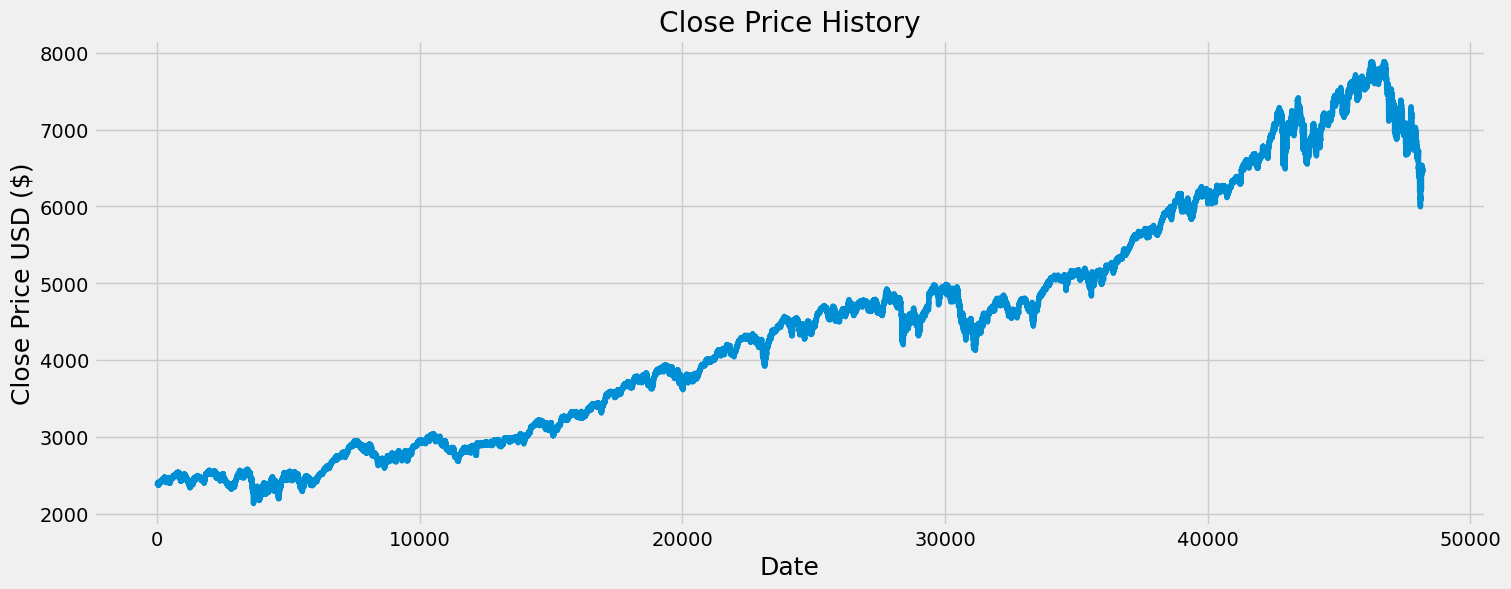

In [24]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(stock_final['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [25]:
data = stock_final.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len
     

45772

In [26]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.03953377],
       [0.03966425],
       [0.03953377],
       ...,
       [0.75209846],
       [0.75662158],
       [0.75775236]])

In [27]:

train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.03953377, 0.03966425, 0.03953377, 0.03983821, 0.04049058,
       0.04066455, 0.04053408, 0.04075153, 0.04053408, 0.04122994,
       0.04118645, 0.0419693 , 0.04166485, 0.04262167, 0.04240421,
       0.04514417, 0.04710129, 0.04684034, 0.04592702, 0.04588353,
       0.04518767, 0.04488323, 0.04462228, 0.04462228, 0.04475275,
       0.04466577, 0.04466577, 0.0450137 , 0.04497021, 0.04510068,
       0.04492672, 0.04440482, 0.04470926, 0.04457878, 0.04505719,
       0.04527465, 0.04588353, 0.04584004, 0.04557909, 0.04549211,
       0.04444831, 0.04310007, 0.04305658, 0.0434915 , 0.04444831,
       0.04457878, 0.0440134 , 0.04375245, 0.04366546, 0.04375245,
       0.04266516, 0.04279563, 0.04292611, 0.04275214, 0.04305658,
       0.04301309, 0.04310007, 0.04183882, 0.04205628, 0.04140391])]
[0.04127343104423087]

[array([0.03953377, 0.03966425, 0.03953377, 0.03983821, 0.04049058,
       0.04066455, 0.04053408, 0.04075153, 0.04053408, 0.04122994,
       0.04118645, 0.0419693 , 0.04

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1))



model = Sequential()
# 1st layer with Dropout regularisation
# * units = add 100 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
# * input_shape => Shape of the training dataset
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# 20% of the layers will be dropped
model.add(Dropout(0.2))
# 2nd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(LSTM(units=50, return_sequences=True))
# 20% of the layers will be dropped
model.add(Dropout(0.2))
# 3rd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(LSTM(units=50, return_sequences=True))
# 50% of the layers will be dropped
model.add(Dropout(0.5))
# 4th LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
model.add(LSTM(units=50))
# 50% of the layers will be dropped
model.add(Dropout(0.5))
# Dense layer that specifies an output of one unit
model.add(Dense(units=1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

45712/45712 [==============================] - 556s 12ms/step - loss: 0.0034


In [29]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

76/76 [==============================] - 2s 6ms/step


528.5500182309843

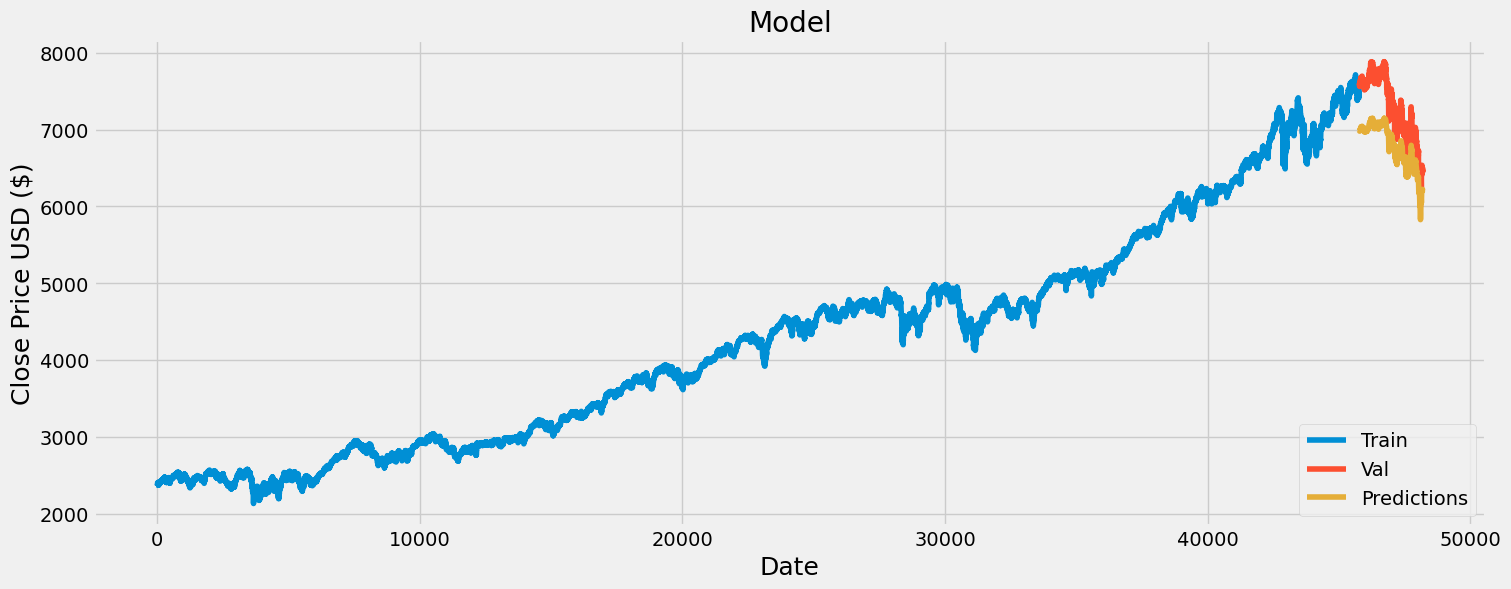

In [30]:

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
     